In [69]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [70]:
def f(x):
    return 3*x+2+x**2

In [71]:
f(2)

12

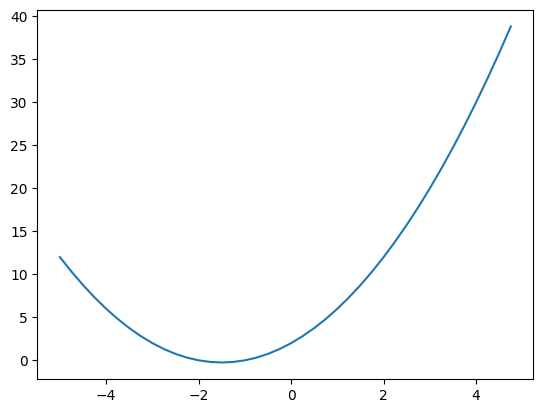

In [72]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [73]:
h=0.00001

a=2
b=-3
c=10

d1 = a*b + c
c+=h
d2 = a*b+c
print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 4
d2 4.00001
slope 0.9999999999621422


In [93]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label=label
        
    def __repr__(self):
        return f"Values(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supports integers,floats"
        out=Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad += (other)*self.data**(other-1)*out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self):
        return self * -1
    
    def __rmul__(self,other):
        return self*other

    def __truediv__(self,other):
        return self * other**-1
    
    

    def __radd__(self,other):
        return self + other
    
    def __sub__(self,other):
        return self + (-other)

    def __rsub__(self,other):
        return other + (-self)

    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x=self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    

In [75]:
from graphviz import Digraph
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})

    nodes,edges = trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid,label="{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name=uid + n._op,label=n._op)
            dot.edge(uid+n._op,uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

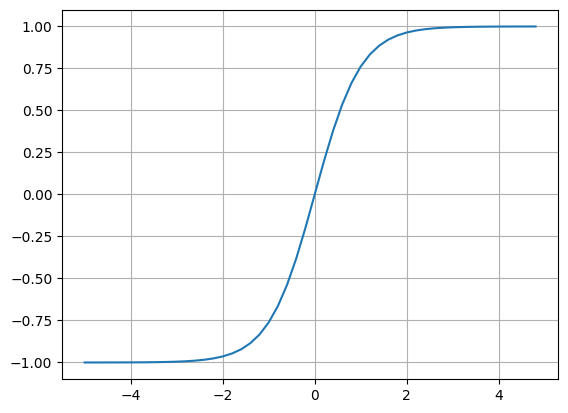

In [76]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid()

In [77]:
#inputs
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias
b=Value(6.8813735870195432,label='b')
x1w1 = x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label = 'x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'
o.backward()

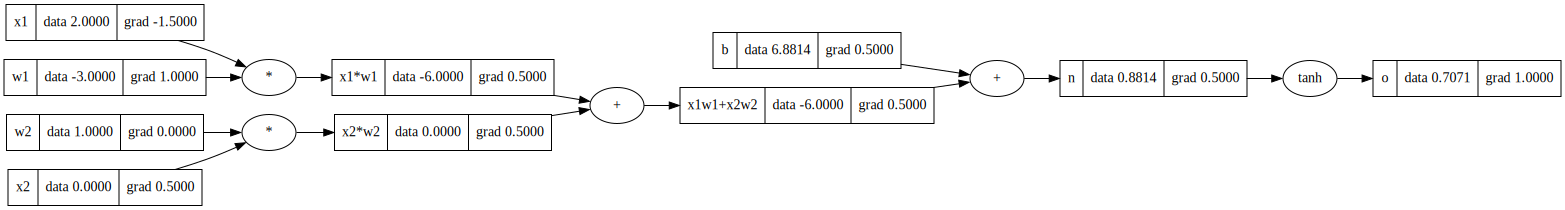

In [78]:
draw_dot(o)

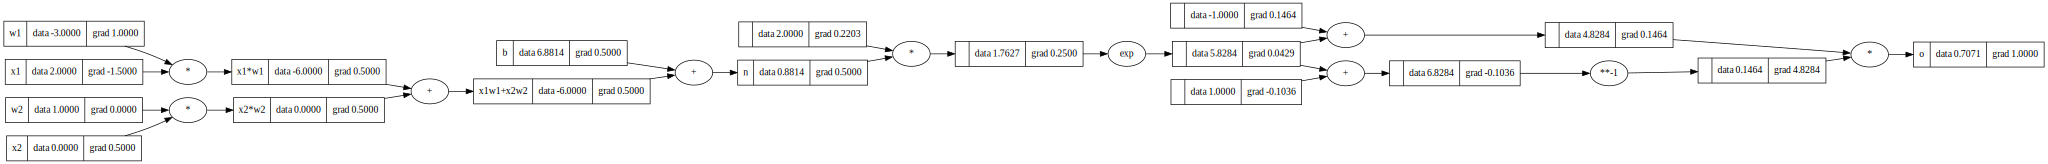

In [79]:
#inputs
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias
b=Value(6.8813735870195432,label='b')
x1w1 = x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label = 'x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)

In [110]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [152]:
x=[2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Values(data=-0.013152467941664166)

In [153]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,1.0,-1.0]
ypred = [n(x) for x in xs]
ypred

[Values(data=-0.013152467941664166),
 Values(data=0.24957943125176715),
 Values(data=0.027086124704543663),
 Values(data=-0.08379768619640897)]

In [177]:
for k in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
    
    for p in n.parameters():
        p.grad=0.0
    loss.backward()


    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k,loss.data)

0 0.009866768466293216
1 0.009736482570723298
2 0.009609442594858008
3 0.009485531341682521
4 0.00936463711447187
5 0.009246653400793338
6 0.009131478577900129
7 0.009019015637855132
8 0.008909171930868025
9 0.008801858925460263


In [178]:
ypred

[Values(data=0.9481688343232723),
 Values(data=-0.9611131245806742),
 Values(data=0.9546807751778672),
 Values(data=-0.9495087337087424)]

In [150]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Values(data=7.999790068981306)

In [151]:
ypred

[Values(data=-0.9999746574598891),
 Values(data=-0.9999745686652532),
 Values(data=-0.9999728591187025),
 Values(data=-0.9999746758031928)]

In [116]:
loss.backward()

In [117]:
n.layers[0].neurons[0].w[0].grad

4.038113709446155

In [149]:
for p in n.parameters():
    p.data -= 0.1*p.grad

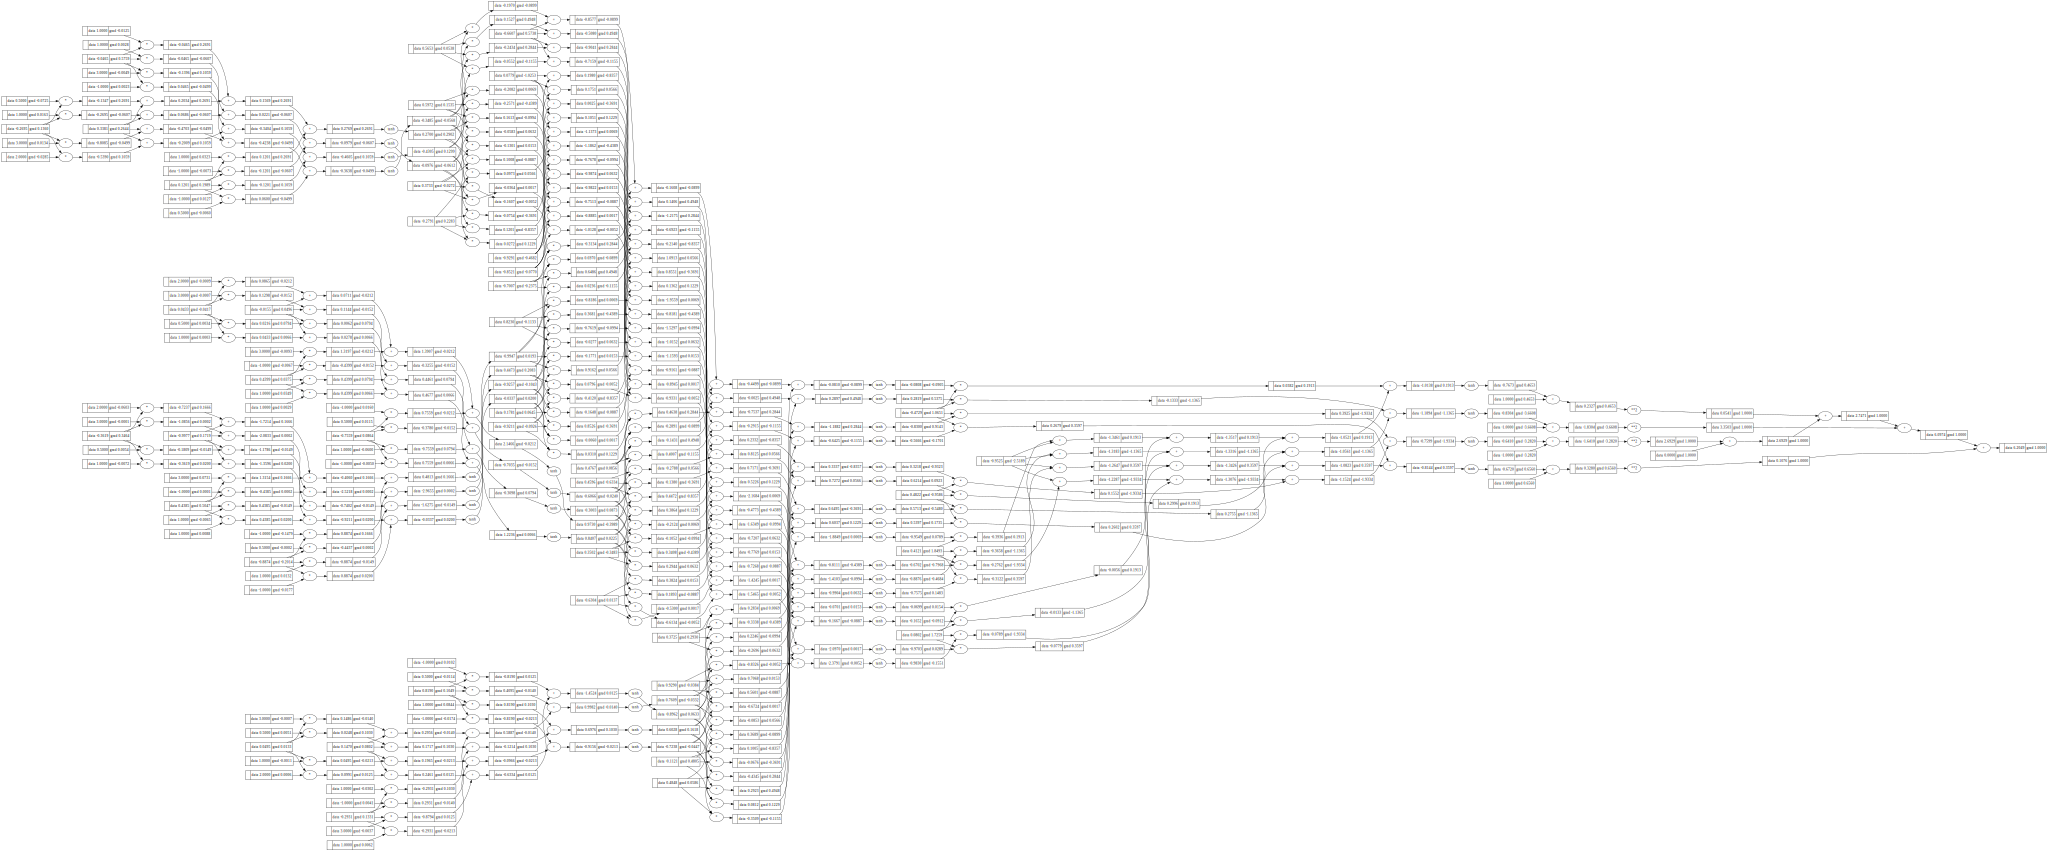

In [101]:
draw_dot(loss)